# Model Creation Notebook

The scope of this notebook is to come up with a model that is capable of reproducing the observed data. The problem, obviously is that the time series is heavily affected by the COVID-19 pandemic.

In order to perform our analysis, we use TensorFlow Probability and CausalImpact libraries. The first will be needed to create a time-series analysis model to predict the number of taxi rides as a function of the day, the latter will be used to quantify the deviation of the post-COVID data from the expectations.

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from google.cloud import bigquery

from causalimpact import CausalImpact

2023-12-06 15:52:53.929403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 15:52:54.985637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-12-06 15:52:54.985761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

We import the data from the `dev` database, and we group them as a function of the day. A finer-grain analysis (with hourly seasonality) may be performed in the future.

In [2]:
dataset_id = "chicago_taxi_trips"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the dataset
dataset_ref = client.dataset(dataset_id=dataset_id)

query_ride_counts = """
SELECT
  *
FROM
  `ml-spec.demo1.group_ride_counts_by_ymdh`
"""

# Create the temporary dataframe
df_tmp = client.query(query_ride_counts).to_dataframe()
df_tmp.rename(columns={'num_trips': 'Number of Trips'}, inplace=True)
df_tmp = df_tmp.set_index(pd.to_datetime(df_tmp[['Year', 'Month', 'Day', 'Hour']]))

# Create the empty dataframe
df = pd.DataFrame(index=pd.date_range(start=df_tmp.index[0], end=df_tmp.index[-1], freq='D'))

# Aggregate the temporary data in terms of the day
num = df_tmp.groupby(
    pd.to_datetime(df_tmp[['Year', 'Month', 'Day', 'Hour']]).dt.strftime('%Y-%m-%d')
).agg({'Number of Trips': sum})
num.index = pd.to_datetime(num.index)

# Save the data in the dataframe
df['Number of Trips'] = num
df['Number of Trips'] = df['Number of Trips'].fillna(0).astype(int)

# Delete the last datapoint, as it does not include a full month
df = df.iloc[:-1]

del df_tmp
del num

df

/var/tmp/ipykernel_1393221/2427531439.py:27: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).agg({'Number of Trips': sum})


,Number of Trips
2013-01-01,56953
2013-01-02,36830
2013-01-03,38808
2013-01-04,50391
2013-01-05,48352
...,...
2023-10-27,20231
2023-10-28,14018
2023-10-29,13321
2023-10-30,15936


We define the function for creating the model, and we give ourselves 2 options:
1. a model with a trend;
2. a model with a local level.

We will assess both of them in order to determine which one is the best at generalizing.

In [3]:
def build_model(y, trend=True):
    """
    Function that, given a time series `y` in the form of a numpy array, returns a model made by the following components:
    - a yearly seasonality;
    - a weekly seasonality;
    - a local linear trend (if `trend` is True), or
    - a local level (if `trend` is False).
    """
    # Number of days per month, starting from year 2013
    num_days_per_month = np.array(
        [[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
        [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31]])

    # Yearly seasonality
    month_of_year = tfp.sts.Seasonal(
        num_seasons=12,
        num_steps_per_season=num_days_per_month,
        observed_time_series=y,
        name='month_of_year')

    # Weekly seasonality
    day_of_week = tfp.sts.Seasonal(
        num_seasons=7,
        num_steps_per_season=1,
        observed_time_series=y,
        name='day_of_week')

    if trend:
        # Local linear trend
        trend = tfp.sts.LocalLinearTrend(
            observed_time_series=y, name='trend')
        components = [trend, day_of_week, month_of_year]
    else:
        # Local level
        level = tfp.sts.LocalLevel(
            observed_time_series=y, name='level')
        components = [level, day_of_week, month_of_year]

    # Sum of the components
    model = tfp.sts.Sum(
        components=components,
        observed_time_series=y)
    
    return model

We build our time-series analysis model atop of the logarithmic values for the following resons:
- this way we rescale the huge variations in the daily data;
- we linearize non-linear trends;
- we avoid the data to become negative, for very long extrapolations.

In [4]:
# Create the y_train data
y_train = np.log10(df['Number of Trips'].values.astype(np.float32) + 1)
y_train

array([4.755524 , 4.5662136, 4.5889325, ..., 4.1245694, 4.2024064,
       4.2108   ], dtype=float32)

Now we need the functions to train the model.

In [5]:
def train_tfp_model(y, model, num_variational_steps_per_iter=1000, learning_rates=[1e-2, 1e-3, 1e-4]):
    """
    Function to use variational inference for training a TensorFlow Probability model.
    It takes the following arguments:
    - `y`, the time series;
    - `model`, the TensorFlow Probability model;
    - `num_variational_steps_per_iter`, the number of epochs for each learning rate value (default is 1000);
    - `learning_rates`, a list with the sequence of the learning rates to use for the training (default is [1e-2, 1e-3, 1e-4]).
    """
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)
    for learning_rate in learning_rates:
        print(f'Learning rate: {learning_rate}')
        # Build and optimize the variational loss function.
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
            target_log_prob_fn=model.joint_distribution(
                observed_time_series=y).log_prob,
            surrogate_posterior=variational_posteriors,
            optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
            num_steps=num_variational_steps_per_iter,
            jit_compile=True)

        plt.plot(elbo_loss_curve)
        plt.show()

    return model


def train_model(y, pre_data_stop, trend):
    """
    Function to train the model.
    It receives the `y` array of data points and the `pre_data_stop` int that defines the index of y starting from which
    the COVID-19 pandemic has an impact on the time series. The last argument is `trend` and it is used to determine whether
    to use a Local Linear Trend (if `True`) or a Local Level (if `False`).
    """
    
    # Create model
    model = build_model(y, trend=trend)

    print('Perform Causal Impact analysis')
    ci = CausalImpact(y,
                      [0, pre_data_stop],
                      [pre_data_stop + 1, len(y) - 1],
                      model=model,
                      model_args={'fit_method': 'vi'})
    ci.plot()
    print(ci.summary())

    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)
    model = train_tfp_model(y[:pre_data_stop],
                            model,
                            num_variational_steps_per_iter=1000,
                            learning_rates=[1e-2, 1e-3, 1e-4])
    
    # Draw samples from the variational posterior.
    q_samples = variational_posteriors.sample(100)

    # Number of data points to forecast for the final plot
    num_steps_forecast = 365 * 4

    # Forecast data
    forecast_dist = tfp.sts.forecast(
        model,
        observed_time_series=y[:pre_data_stop],
        parameter_samples=q_samples,
        num_steps_forecast=num_steps_forecast)

    forecast_mean = forecast_dist.mean().numpy()[..., 0]

    # Plot the model
    fig, ax = plt.subplots(1, figsize=(16, 9))
    sns.lineplot(y, ax=ax)
    sns.lineplot(x=range(pre_data_stop, pre_data_stop + num_steps_forecast),
                 y=forecast_mean, ax=ax)
    
    return model, ci

2023-12-05 12:37:12.931202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-05 12:37:12.931284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (demo-1-chicago-dataset): /proc/driver/nvidia/version does not exist
2023-12-05 12:37:12.933177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Perform Causal Impact analysis


/opt/conda/lib/python3.10/site-packages/causalimpact/data.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():


Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


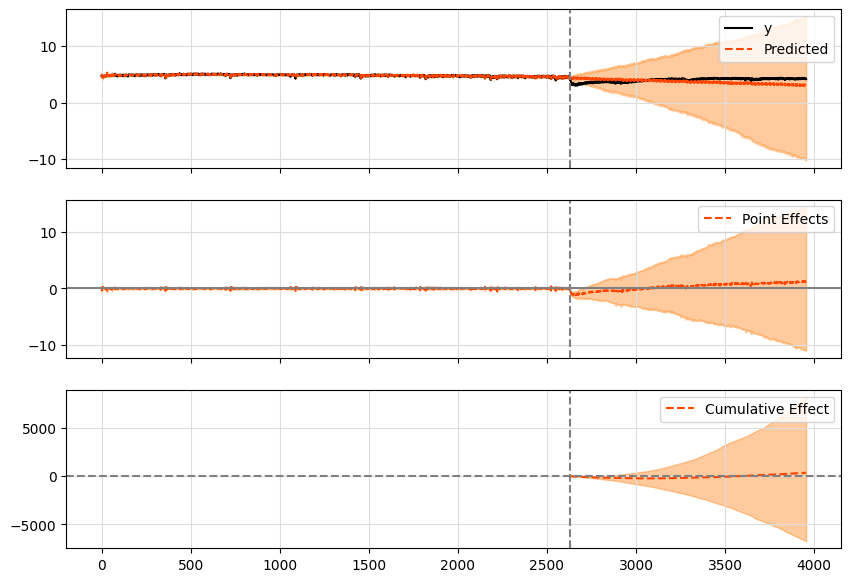

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    4.03               5342.47
Prediction (s.d.)         3.75 (3.1)         4981.07 (4116.54)
95% CI                    [-2.46, 9.7]       [-3264.84, 12871.69]

Absolute effect (s.d.)    0.27 (3.1)         361.4 (4116.54)
95% CI                    [-5.67, 6.49]      [-7529.22, 8607.31]

Relative effect (s.d.)    7.26% (82.64%)     7.26% (82.64%)
95% CI                    [-151.16%, 172.8%] [-151.16%, 172.8%]

Posterior tail-area probability p: 0.44
Posterior prob. of a causal effect: 56.24%

For more details run the command: print(impact.summary('report'))
Learning rate: 0.01


2023-12-05 12:44:19.993081: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x56025fafdbd0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-05 12:44:19.993133: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-12-05 12:44:20.311791: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed
2023-12-05 12:44:20.337994: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer

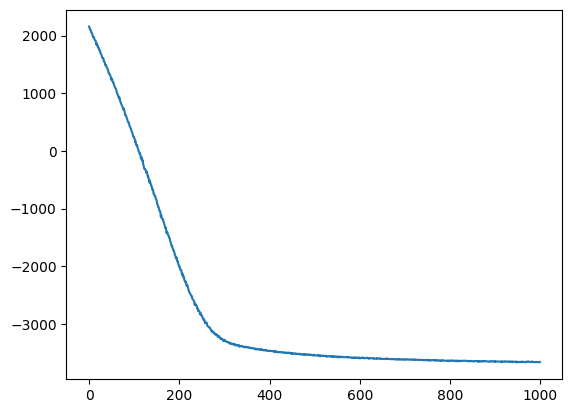

Learning rate: 0.001


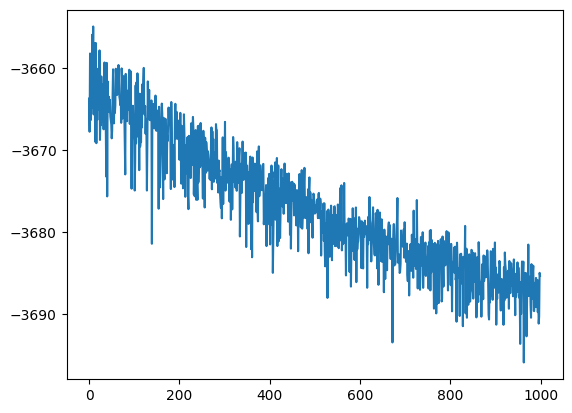

Learning rate: 0.0001


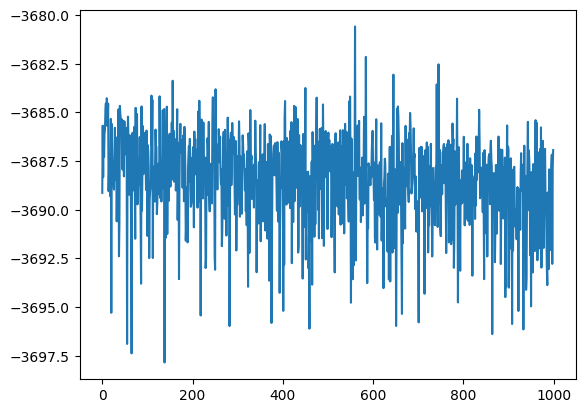

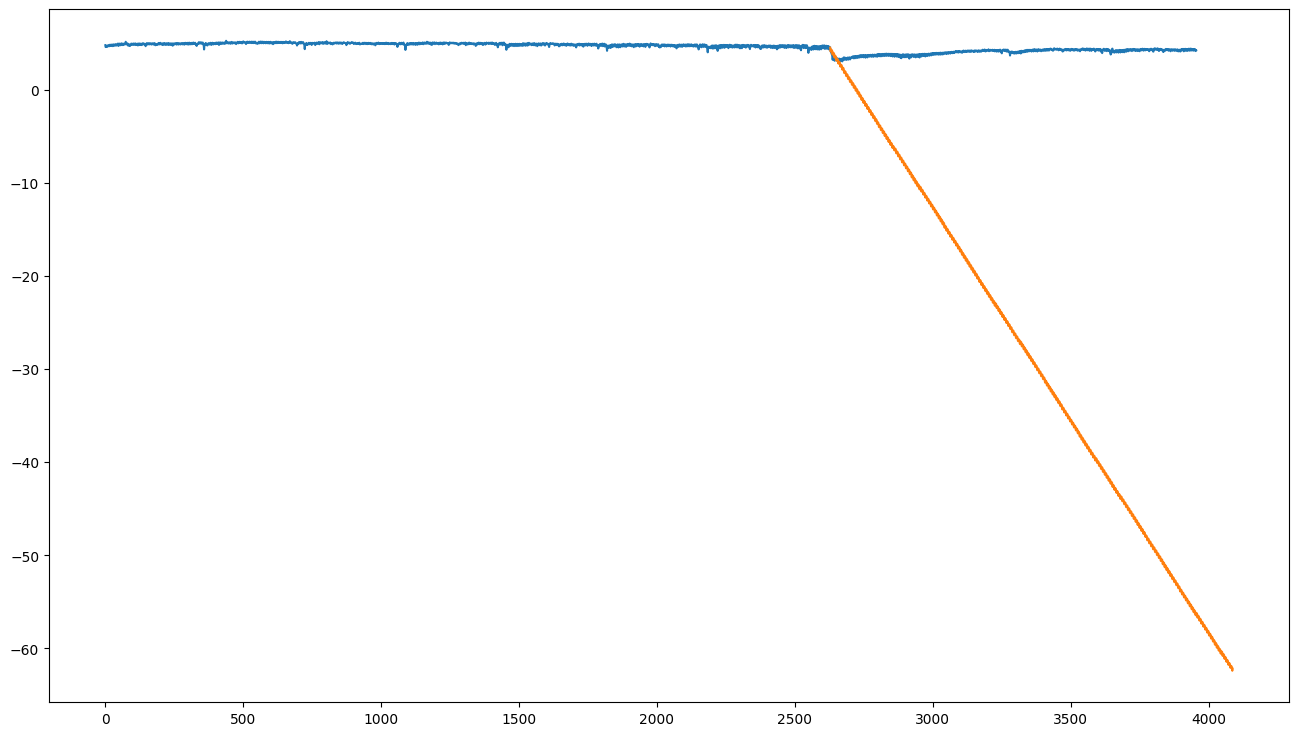

In [6]:
model, ci = train_model(y_train, 2628, trend=True)

From the last plot, it is obvious that the fit is unsatisfying. Let us repeat the analysis by switching the Local Linear Trend with a Local Level.

Perform Causal Impact analysis


/opt/conda/lib/python3.10/site-packages/causalimpact/data.py:263: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():


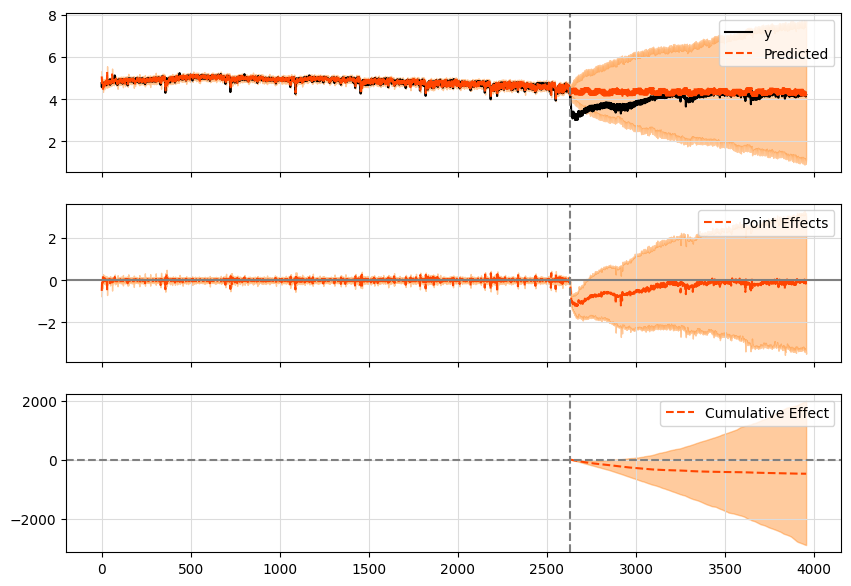

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    4.03               5342.47
Prediction (s.d.)         4.38 (0.93)        5818.86 (1233.4)
95% CI                    [2.66, 6.31]       [3536.31, 8371.16]

Absolute effect (s.d.)    -0.36 (0.93)       -476.39 (1233.4)
95% CI                    [-2.28, 1.36]      [-3028.69, 1806.15]

Relative effect (s.d.)    -8.19% (21.2%)     -8.19% (21.2%)
95% CI                    [-52.05%, 31.04%]  [-52.05%, 31.04%]

Posterior tail-area probability p: 0.32
Posterior prob. of a causal effect: 67.93%

For more details run the command: print(impact.summary('report'))
Learning rate: 0.01


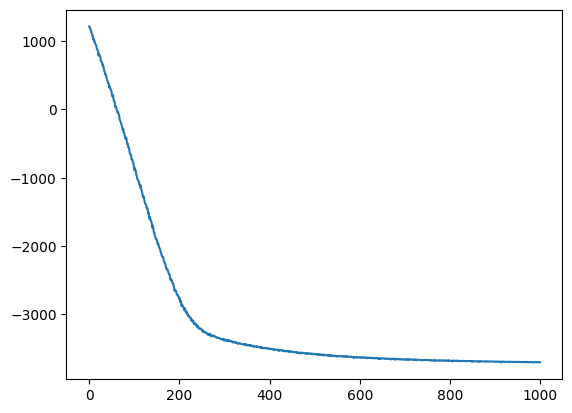

Learning rate: 0.001


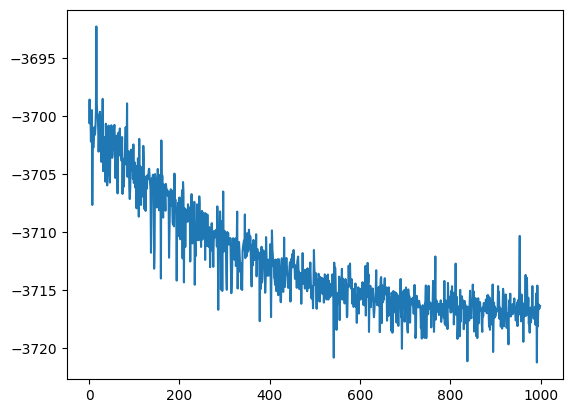

Learning rate: 0.0001


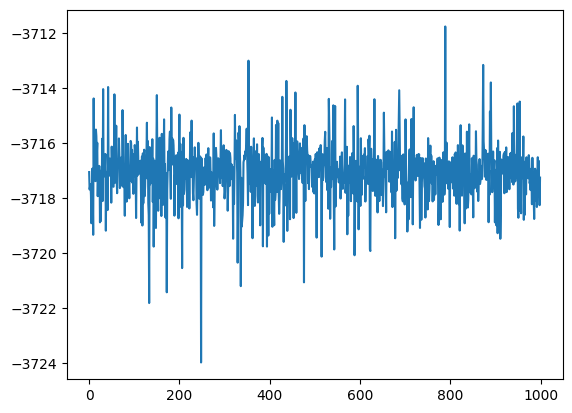

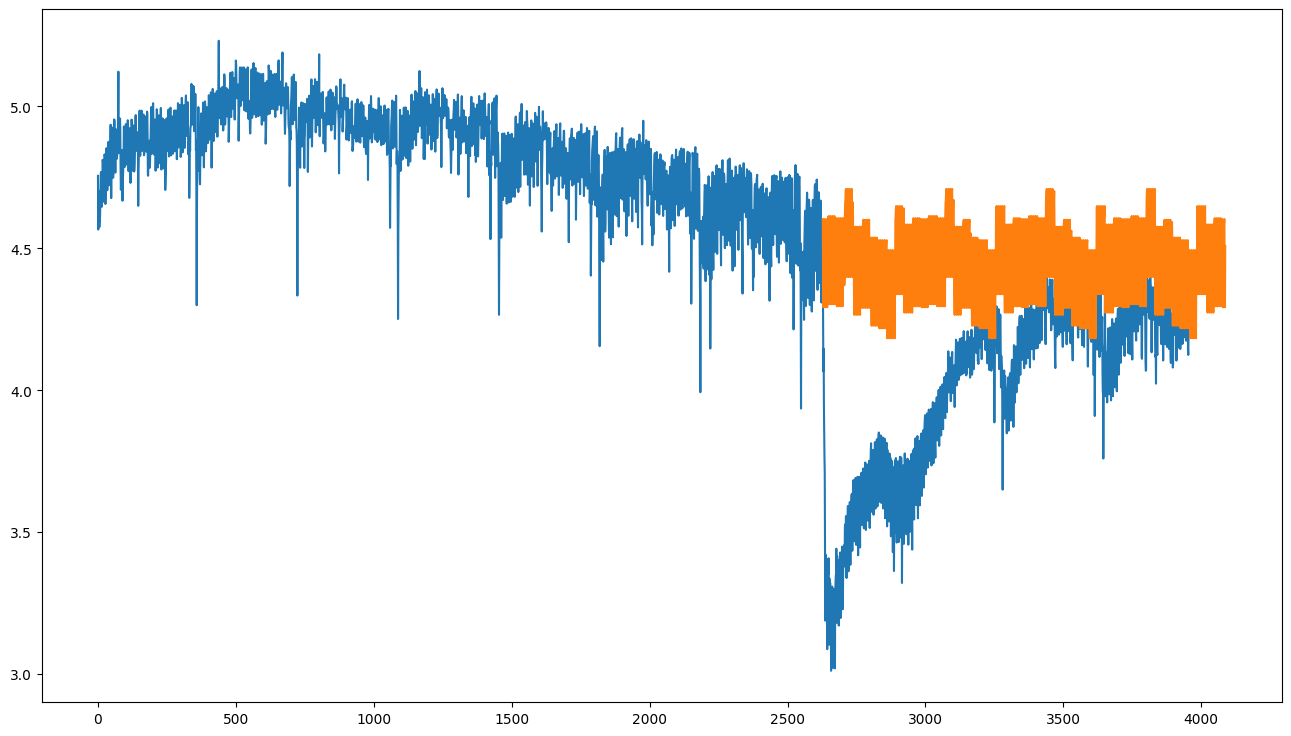

In [7]:
model, ci = train_model(y_train, 2628, trend=False)

The Local Level appears to perform much better than the Local Linear Trend, so we use this component for the final model.

Moreover, it is evident that the COVID-19 effect has ceased to exist and the trend of the latest ~500 days is again what one could expect if the pandemic had not happened.

In [10]:
model_path = os.path.join('..', 'data', 'model')
for component in ci.model.components:
    print(component.name)
    joblib.dump(component.init_parameters,
                f'{os.path.join(model_path, component.name[:-1])}.joblib')

level/
day_of_week/
month_of_year/


In [11]:
components = model.components

covid_start = 2628
covid_stop = 3500

is_missing = [False]* covid_start + [True] * (covid_stop - covid_start) + [False] * (y_train.size - covid_stop)

y_train_masked = tfp.sts.MaskedTimeSeries(y_train, is_missing)

masked_model = tfp.sts.Sum(
        components=components,
        observed_time_series=y_train_masked)

<Axes: >

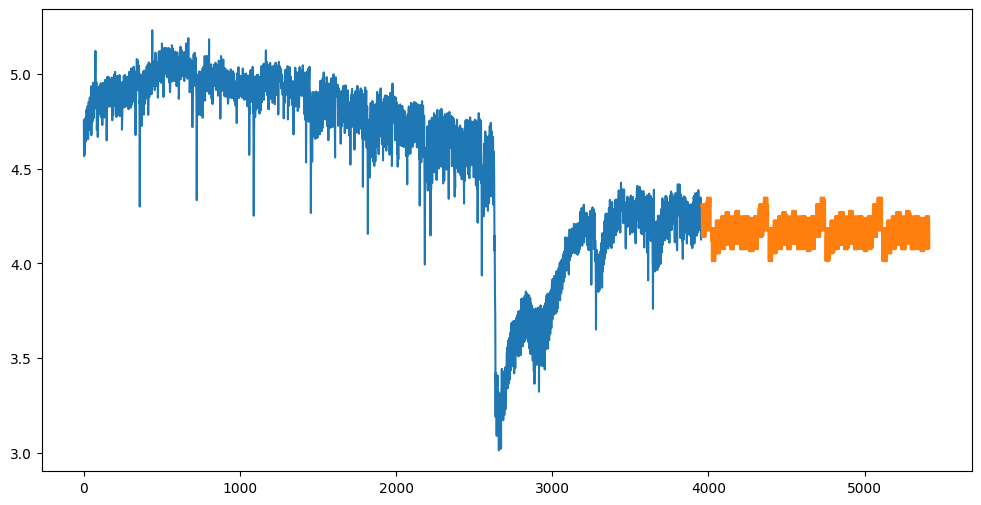

In [13]:
masked_model = train_tfp_model(y_train_masked, masked_model, num_variational_steps_per_iter=1000, learning_rates=[1e-2, 1e-3, 1e-4])

# Draw samples from the variational posterior.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=masked_model)
q_samples = variational_posteriors.sample(100)

# Number of data points to forecast for the final plot
num_steps_forecast = 365 * 4

# Forecast data
forecast_dist = tfp.sts.forecast(
    masked_model,
    observed_time_series=y_train_masked,
    parameter_samples=q_samples,
    num_steps_forecast=num_steps_forecast)

forecast_mean = forecast_dist.mean().numpy()[..., 0]

# Plot the model
fig, ax = plt.subplots(1, figsize=(12, 6))
sns.lineplot(y_train, ax=ax)
sns.lineplot(x=range(y_train.size, y_train.size + num_steps_forecast),
             y=forecast_mean, ax=ax)

This result is more than satisfying for the demo, so we created a function that encompasses the whole procedure followed till here. Let us try it out to ensure that it works.

2023-12-06 17:59:35.374523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 17:59:36.498829: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-12-06 17:59:36.498943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Learning rate: 0.01
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2023-12-06 17:59:59.966914: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55932c81ebf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-12-06 17:59:59.966957: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-12-06 18:00:00.238402: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed
2023-12-06 18:00:00.260003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer

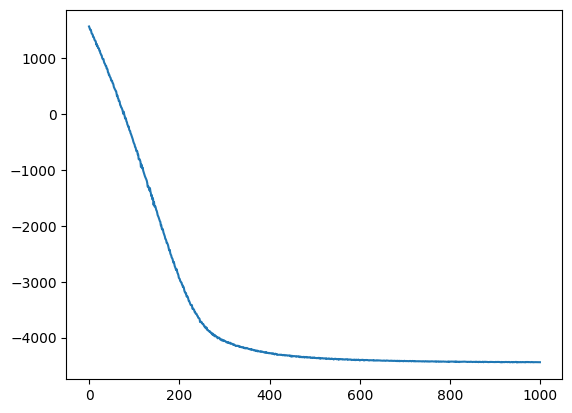

Learning rate: 0.001


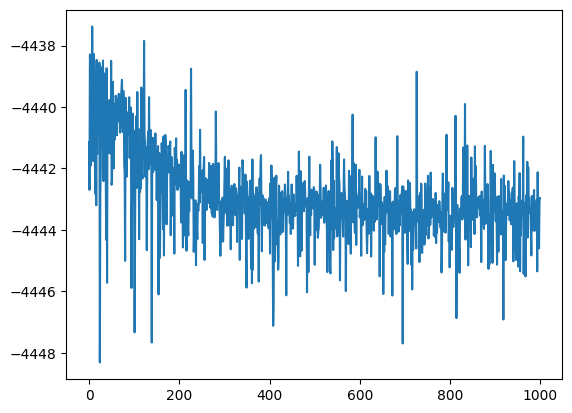

Learning rate: 0.0001


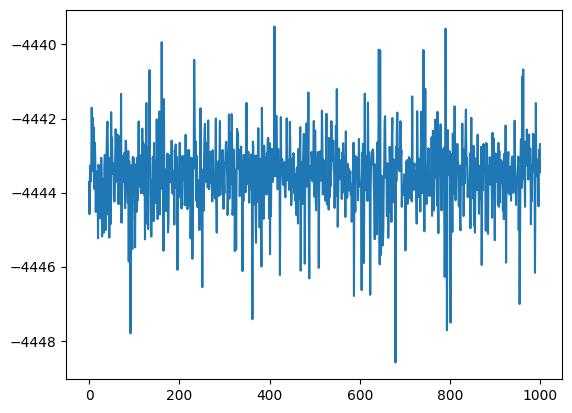

21132

In [1]:
import os
import sys

local_path = os.getcwd()
src_path = os.sep.join(local_path.split(os.sep)[:-1])

sys.path.append(src_path)

from demo_lib import *

model, y_train_masked = create_masked_model(learning_rates=[1e-2, 1e-3, 1e-4])
save_model(model, y_train_masked)
forecast(*load_model(), "2023-11-30")

Therefore, the library works as intended.